In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import labolibrary as labo
import pickle
from sklearn.preprocessing import RobustScaler,PowerTransformer
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [26]:

#DATOS_DIR = '~/buckets/b1/datasets/'
DATOS_DIR = '../data/'      

scalers = {}
# Function to center, scale, and return a series
def scale_group(group):
    scaler = RobustScaler()
    #scaler = PowerTransformer()
    scaled_values = scaler.fit_transform(group.values.reshape(-1, 1)).flatten()
    scalers[group.name] = scaler  # Store the scaler for this group
    return pd.Series(scaled_values, index=group.index, name=group.name)

# Function to inverse transform (de-scale) and decenter, and return a series
def inverse_scale_group(group):
    group_name = group.name
    scaler = scalers[group_name]
    inversed_centered_values = scaler.inverse_transform(group.values.reshape(-1, 1)).flatten()
    original_values = inversed_centered_values
    return pd.Series(original_values, index=group.index, name=group_name)


In [27]:

# Leer datos
#df_final = pd.read_parquet(DATOS_DIR+'FE_dataset-CARLA.parquet') 
#import dask.dataframe as dd
df_final = pd.read_parquet(DATOS_DIR+'FE_06_dataset.parquet') 
#df_final = df_final.compute()

df_final.columns = df_final.columns.str.replace(' ', '_').str.replace(r'[^A-Za-z0-9_]', '', regex=True)




In [28]:

## ESTO ES UN HACK PORQUE ESTA MAL ARMADA LA FUNCIÓN DE ESCALADO Y SOLO GUARDA LOS DATOS DE LA ÜLTIMA APLICACIÓN

with open(DATOS_DIR + '/scalers.pkl', 'rb') as file:
    scalers = pickle.load(file)

#df_test = df_final[(df_final['product_id'] == 21276) & (df_final['customer_id'] == 10029)][['product_id','tn', 'weight']]
#df_test['tn'] = df_test.groupby('product_id')['tn'].transform(inverse_scale_group)

#df_test

In [29]:

### Filtrar datos
df_true = df_final.loc['2019-12-01':'2020-01-01']
df_final = df_final.loc['2018-01-01':'2019-09-01']


In [30]:
df_true = df_true[['product_id','customer_id','tn']]
df_true

,product_id,customer_id,tn
periodo,,,
2019-12,20426,10217,2.688256
2019-12,20132,10378,0.016380
2019-12,20852,10125,0.000000
2019-12,20473,10125,0.000000
2019-12,20101,10358,0.400000
...,...,...,...
2019-12,20208,10153,0.000000
2019-12,20310,10103,0.000000
2019-12,20354,10003,1.005863


In [31]:
df_true['tn'] = df_true.groupby(['product_id','customer_id'])['tn'].transform(inverse_scale_group)
pred_true = df_true.groupby(['product_id'])['tn'].sum()
pred_true.to_csv(DATOS_DIR+'/pred/TRUE-NOVEMBER.csv', index=True,header=True)


In [32]:
#df_final[df_final['product_id'] == 20402 & df_final['customer_id'] == 10479][['product_id','tn']]

In [33]:

#Filtro test
#df_final = df_final[df_final['product_id'] < 20013]
#df_final = df_final[df_final['product_id'] == 20072]

weight= df_final[['weight','product_id','customer_id']]
#df_final.drop(columns=['weight'], inplace=True)
#filtered_weight = weight[weight['weight'] != 0]
#weight_mean = filtered_weight.groupby('product_id')['weight'].mean().to_dict()
#weight['weight'] = weight['product_id'].map(weight_mean)

weight = weight.groupby(['product_id','customer_id'])['weight'].mean()
weight = weight.reset_index()
df_final = df_final.drop(columns=['weight'])

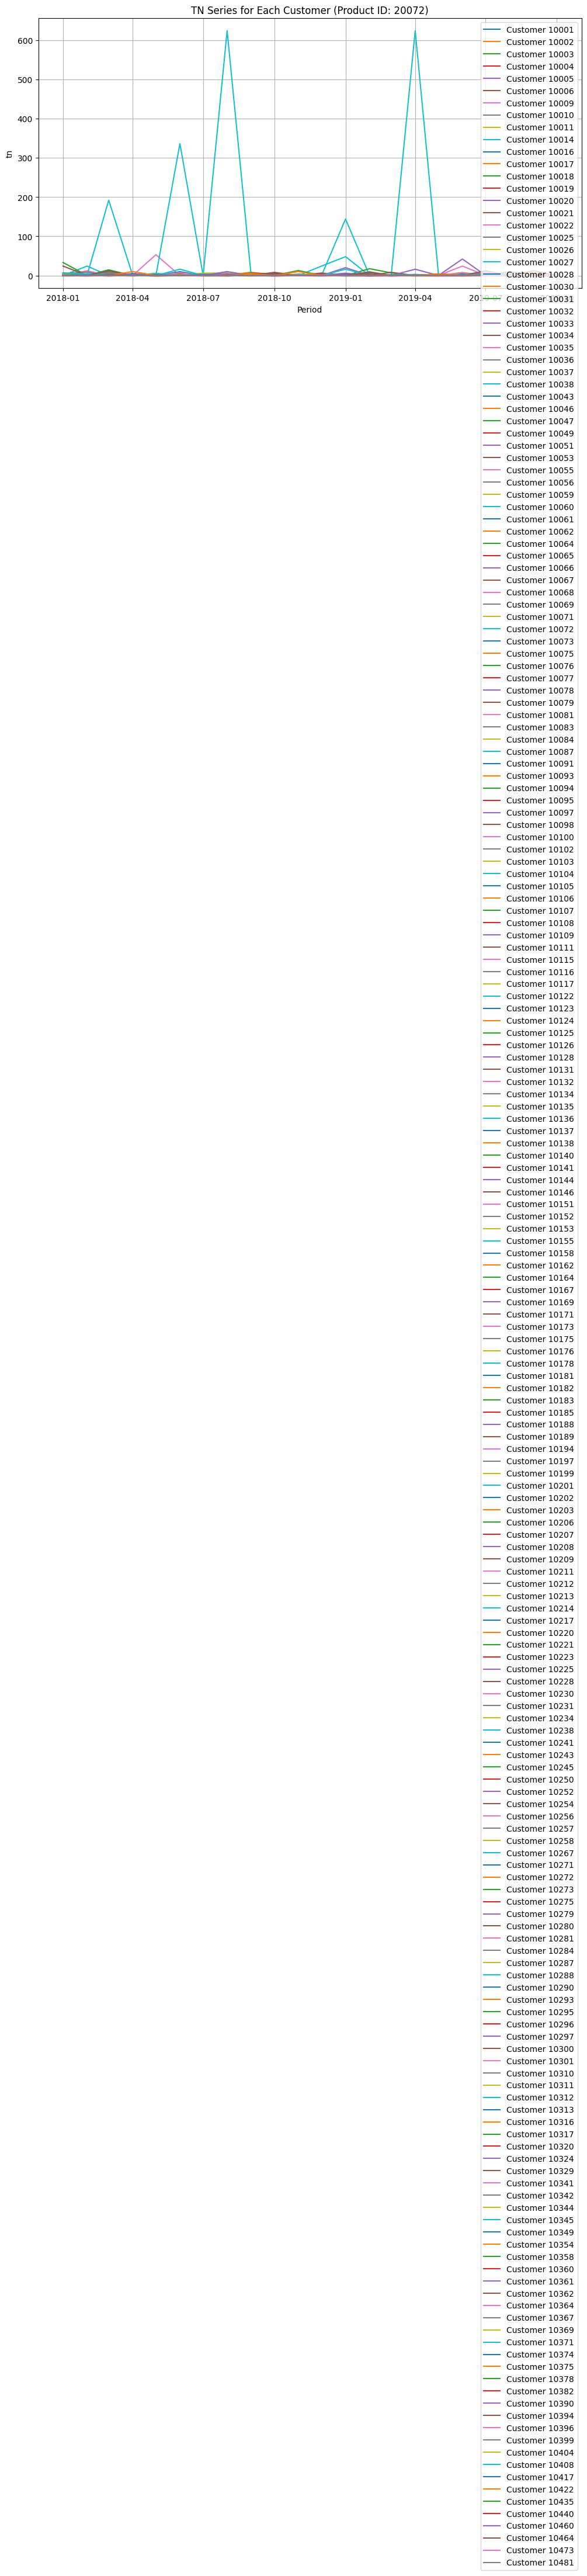

In [44]:
""" import matplotlib.pyplot as plt
import pandas as pd

# Pivot the dataframe to have customer_id as columns and periodo as the index
df_filtered_product = df_final.copy()
df_filtered_product.reset_index(inplace=True)
df_pivot = df_filtered_product.pivot(index='periodo', columns='customer_id', values='tn_2')

# Convert 'periodo' from PeriodIndex to Timestamp
df_pivot.index = df_pivot.index.to_timestamp()

# Plot the series
plt.figure(figsize=(12, 6))
for column in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[column], label=f'Customer {column}')

plt.xlabel('Period')
plt.ylabel('tn')
plt.title(f'TN Series for Each Customer (Product ID: 20072)')
plt.legend()
plt.grid(True)
plt.show() """


In [ ]:
# Correr Modelo
params={
        'boosting_type': 'gbdt',
        'objective': 'Regression',
        'metric':'rmse',
        'verbose': -1,
        #'n_jobs': -1,
        'seed': 10000079,
        #'learning_rate': 0.2,
        #'bagging_fraction': 0.85,
        #'bagging_freq': 1, 
        #'colsample_bytree': 0.85,
        #'colsample_bynode': 0.85,
        #'min_data_per_leaf': 25,
        #'num_leaves': 200,
        #'lambda_l1': 0.5,
        #'lambda_l2': 0.5
}

predictions_all = pd.DataFrame(columns=['tn'])
products = df_final['product_id'].unique()
tot = len(products)
nro = 0
for producto in products:
    print(f'Fitting and predicting for product_id: {producto}')
    # Filtrar los datos del producto
    df_producto = df_final[df_final['product_id'] == producto]
    
    product_weights = pd.merge(df_producto.reset_index(), weight, on=['product_id', 'customer_id'], how='left')
    product_weights.set_index('periodo', inplace=True)
    weight_p = product_weights['weight']
   
    
    # Prepare data for LSTM on tn_2 only
    X = df_producto[['tn_2']].values.astype('float32')
    y = df_producto['tn_2'].fillna(0).values.astype('float32')
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    #######################################################    
    # Define LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy')

    # Train LSTM model
    model.fit(X, y, epochs=10, batch_size=32, verbose=1)

    # Extract features from LSTM
    features = model.predict(X)

    # Prepare data for LightGBM
    # Convert LSTM features to DataFrame
    features_df = pd.DataFrame(features, index=df_producto.index, columns=[f'lstm_feature_{i}' for i in range(features.shape[1])])
    df_producto = pd.concat([df_producto, features_df], axis=1)
    df_producto['tn_2'] = y
    
    #############################################################################  
    #### Agrupar y escalar
   
    model, average_metric = labo.train_lightgbm_model(df_producto,params,metric='rmse',
                                                      weights=weight_p)
    print("Overall rmse metric: ", average_metric)
    # Predict values for the entire dataset using the trained models
    # Prepare last data points for prediction
    last_data_points = df_producto[df_producto.index == df_producto.index.max()].copy()
    last_data_points.drop(columns=['tn_2'], inplace=True)
    # Predict the next month's value using the trained model
    predictions = labo.predict_next_month_customer(model, last_data_points)
    preds = predictions.groupby(['product_id','customer_id'])['tn_2'].transform(inverse_scale_group)
    predictions['tn'] = preds
    predictions.drop(columns=['tn_2'], inplace=True)
    predictions = predictions.reset_index()
    predictions =  predictions.groupby('product_id')['tn'].sum()
    predictions.columns = ['product_id', 'tn']
    predictions_all = pd.concat([predictions_all, predictions])
    print(predictions_all[-1:])


In [ ]:

predictions_all['tn']=predictions_all['tn'].astype('float32')
predictions_all.index.names = ['product_id']
predictions_all.to_csv(DATOS_DIR+'/pred/0026-prediccion-RSME_scaled_Robust-product_id_LSTM-STUPID.csv', index=True,header=True)
print("Overall custom metric: ", average_metric)


In [24]:

# Convert the Polars dataframe to a Pandas dataframe
df_group_pd = df_final
df_group_pd = df_group_pd.reset_index()

# Filter the dataframe for the specified product_id
df_filtered_product = df_group_pd[df_group_pd['product_id'] == '20072' ]

df_filtered_product


,periodo,customer_id,product_id,periodo_min,periodo_max,cust_request_qty,cust_request_tn,tn,count,tn_2,...,Promedio_de_uva_diario,eph_continua_tasa_desempleo_total,Promedio_de_merval,remun_imponible_promedio,ipim_nivel_general,ipc_nucleo,Promedio_de_tipo_cambio_implicito_en_adrs,expectativa_inflacion_promedio,tasas_interes_badlar,ff_eeuu_tasa
